# Inference of parameters (SEAI5R model)
In this notebook, we consider the SEAI5R model with various stages of infection: exposed, activated, asymptomatic infected, symptomatic infected, hospitalised, critial and mortality. We are trying to infer the following parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)

when given full data of all the classes from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAI5R_traj.npy', data_array)

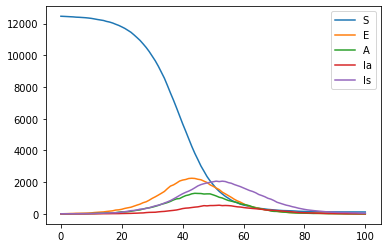

In [5]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

## 2) Inference
We take the first $30$ data points of the trajectory and use it to infer the parameters of the model.

In [9]:
# load the data and rescale to intensive variables 
Tf_inference = 30 
Nf_inference = Tf_inference + 1 

x = np.load('SEAI5R_traj.npy').astype('float')
x = x[:Nf_inference,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-4556.54214844245
0.7192268371582031


In [16]:
eps = 1e-4 

alpha_g = 0.3         
alpha_std = 0.1
alpha_b = (eps, 0.5)

beta_g  = 0.1        
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.3
gE_std = 0.1
gE_b = (eps, 1)

gA_g    = 0.3 
gA_std = 0.1
gA_b = (eps, 1) 
   

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])
                   
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]) 
                   
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std]) 
            
start_time = time.time()
params = estimator.inference(guess, stds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds=bounds, 
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=1058418, Thu May  7 19:45:43 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.988763379942046e+03 1.0e+00 9.04e-01  4e-02  9e-02 0:15.5
    2     32 -3.562273898432636e+03 1.3e+00 9.64e-01  4e-02  1e-01 0:31.0
    3     48 -4.275543600005411e+03 1.5e+00 8.99e-01  4e-02  1e-01 0:45.7
    4     64 -4.216196541386247e+03 1.7e+00 9.87e-01  5e-02  1e-01 0:59.8
    5     80 -3.679738520923574e+03 1.9e+00 1.09e+00  6e-02  1e-01 1:14.2
    6     96 -4.171277216882812e+03 2.0e+00 1.10e+00  5e-02  1e-01 1:26.1
    7    112 -3.881670936824326e+03 2.0e+00 1.02e+00  5e-02  1e-01 1:36.4
    8    128 -3.816151579973921e+03 2.0e+00 9.60e-01  4e-02  1e-01 1:47.3
   10    160 -4.208803389015926e+03 2.2e+00 8.83e-01  3e-02  9e-02 2:04.7
   11    176 -4.347157454347640e+03 2.2e+00 7.54e-01  3e-02  8e-02 2:14.1
   13    208 -4.383892794128138e+03 2.4e+00 7.30e-01  2e-02  8e-

In [17]:
# save the parameters 
np.save('SEAI5R_param.npy', params)

In [18]:
print('True parameters')
print(parameters)

best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'gE': 0.2, 'gA': 0.3333333333333333, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.1, 0.1]), 'cc': array([0.05, 0.05]), 'mm': array([0.4, 0.4])}

 Best estimates
{'alpha': 0.15060364497701098, 'beta': 0.02012284383217044, 'gIa': 0.12944407481891285, 'gIs': 0.11820746342938995, 'gE': 0.19208977254411624, 'gA': 0.34217984273370977, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.1, 0.1]), 'cc': array([0.05, 0.05]), 'mm': array([0.4, 0.4])}


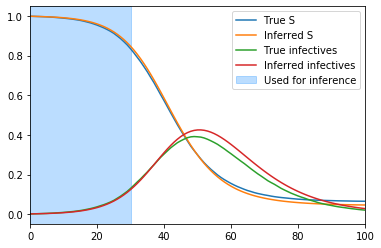

In [20]:
x0 = x[0] 
det_model = pyross.deterministic.SEAI5R(best_estimates, int(M), fi)
estimator.set_params(best_estimates)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('SEAI5R_latent_traj.npy').astype('float')[:, :8*M]/N

plt.plot(np.sum(x[:,0:M], axis=1), label='True S')
plt.plot(np.sum(x_det[:,0:M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:,M:], axis=1), label='True infectives')
plt.plot(np.sum(x_det[:, M:], axis=1), label='Inferred infectives')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()